# Setting

### Connect GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content
!mkdir result
!cp -r /content/drive/MyDrive/capstone/. /content/.

/content


### Install Package

In [ ]:
!pip3 install mtcnn filterpy lap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.1 MB/s 
     |████████████████████████████████| 177 kB 63.3 MB/s 
     |████████████████████████████████| 1.5 MB 59.1 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=cc25e81b2435d1e022ec3bd8f24bb0c9bb3c50bc14124b70da06cc69b0cb1810
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590226 sha256=8189c80adbbbfd73971abe46b59c347531d62659ad21a1b5d313a56ad97372f3
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built filterpy lap


### Start

In [ ]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
import joblib
import timeit
import cv2
from tqdm import tqdm
from sort import *
from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt
# from mtcnn import MTCNN



def extract_face(filename, required_size=(160, 160)):
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = asarray(image)
  detector = MTCNN()
  results = detector.detect_faces(pixels)
  x1, y1, width, height = results[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = pixels[y1:y2, x1:x2]
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array


def load_faces(directory):
  faces = []
  for filename in listdir(directory):
    if filename == '.DS_Store':
      continue
    path = directory + filename
    face = extract_face(path)
    faces.append(face)
  return faces


def load_dataset(directory):
  X, y = [], []
  for subdir in listdir(directory):
    if subdir == '.DS_Store':
      continue
    path = directory + subdir + '/'
    if not isdir(path):
      continue
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    X.extend(faces)
    y.extend(labels)

  return asarray(X), asarray(y)


def get_embedding(model, face_pixels):
	face_pixels = face_pixels.astype('int32')
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	samples = expand_dims(face_pixels, axis=0)
	yhat = model.predict(samples)
	return yhat[0]


def euclidean_distance(a, b):
  x1, y1 = a
  x2, y2 = b
  return math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1))


def alignment_procedure(img, left_eye, right_eye):
  left_eye_x, left_eye_y = left_eye
  right_eye_x, right_eye_y = right_eye

  if left_eye_y > right_eye_y: # 왼쪽으로 기울어진 경우
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 # 시계방향으로 회전
  else: # 오른쪽으로 기울어진 경우
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 # 시계반대방향으로 회전

  a = euclidean_distance(np.array(left_eye), np.array(point_3rd))
  b = euclidean_distance(np.array(right_eye), np.array(point_3rd))
  c = euclidean_distance(np.array(right_eye), np.array(left_eye))

  if b != 0 and c != 0:
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi

    if direction == -1:
      angle = 90 - angle

    img = Image.fromarray(img)
    img = np.array(img.rotate(direction * angle))

  return img


# def make_mosaic(img, x, y, w, h):
#   face_region = img[y: y+h, x: x+w]
#   face_region = cv2.resize(face_region, dsize=(0, 0), fx=0.05, fy=0.05, interpolation=cv2.INTER_AREA)
#   face_region = cv2.resize(face_region, dsize=(w, h), interpolation=cv2.INTER_AREA)
#   img[y: y+h, x: x+w] = face_region

#   return img


def mosaic(src, ratio=0.1):
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    return cv2.resize(small, src.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)


def make_mosaic(src, x, y, width, height, ratio=0.05):
    dst = src.copy()
    dst[y:y + height, x:x + width] = mosaic(dst[y:y + height, x:x + width], ratio)
    return dst

# Face Dataset

### Save Dataset

In [ ]:
# Save Dataset
# trainX, trainy = load_dataset('/content/face_dataset/train/')
# print(trainX.shape, trainy.shape)
# testX, testy = load_dataset('/content/face_dataset/val/')
# print(testX.shape, testy.shape)

# savez_compressed('face_dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# 드라이브에 저장하기
# !cp -r /content/face_dataset.npz /content/drive/MyDrive/capstone/.

### Load Dataset

In [ ]:
data = load('/content/face_dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('불러오기: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

불러오기:  (300, 160, 160, 3) (300,) (150, 160, 160, 3) (150,)


# Face Embedding

### Load Model

In [ ]:
# facenet 모델 불러오기
facenet = load_model('/content/facenet/model/facenet_keras.h5')

### Save Embeddings

In [ ]:
# newTrainX = list()
# for face_pixels in trainX:
# 	embedding = get_embedding(facenet, face_pixels)
# 	newTrainX.append(embedding)
# newTrainX = asarray(newTrainX)
# print(newTrainX.shape)

# newTestX = list()
# for face_pixels in testX:
# 	embedding = get_embedding(facenet, face_pixels)
# 	newTestX.append(embedding)
# newTestX = asarray(newTestX)
# print(newTestX.shape)

# savez_compressed('face_embeddings.npz', newTrainX, trainy, newTestX, testy)
# !cp -r /content/face_embeddings.npz /content/drive/MyDrive/capstone/. # 드라이브에 복사하기

### Load Embeddings

In [ ]:
data = load('/content/face_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('데이터셋: 훈련 %d개, 테스트 %d개' % (trainX.shape[0], testX.shape[0]))

데이터셋: 훈련 300개, 테스트 150개


# Face Classfication

### Load Dataset

In [ ]:
# Test 얼굴 데이터셋 불러오기
data = load('/content/face_dataset.npz')
testX_faces = data['arr_2']

# 얼굴 임베딩 불러오기
data = load('/content/face_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [ ]:
# 입력 벡터 일반화
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# 목표 레이블 암호화
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

### Train

In [ ]:
# 모델 학습
clf = SVC(kernel='linear', probability=True)
clf.fit(trainX, trainy)

### Save Model

In [ ]:
# 모델 저장하기
joblib.dump(clf, 'face_clf.pkl')
# !cp -r /content/face_clf.pkl /content/drive/MyDrive/capstone/.

### Load Model

In [ ]:
# 모델 불러오기
clf = joblib.load('/content/face_clf.pkl')

### Test

예상: donghyun (80.294)
추측: donghyun


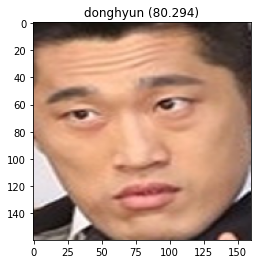

In [ ]:
# 테스트셋 랜덤 얼굴
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# 얼굴 예측
samples = expand_dims(random_face_emb, axis=0)
yhat_class = clf.predict(samples)
yhat_prob = clf.predict_proba(samples)

# 이름 얻기
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('예상: %s (%.3f)' % (predict_names[0], class_probability))
print('추측: %s' % random_face_name[0])

# 그리기
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

# Face Tracking

In [ ]:
# capture object
PATH = "/content/sample/"
SAVEPATH = "/content/result/"
filename = "video-sample"

cap = cv2.VideoCapture(PATH + filename + ".mp4")

if not cap.isOpened():
  print("Cannot open video file")
  exit()

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print(f"width {width}, height {height}, fps {fps}")

fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter(SAVEPATH + filename + ".mp4", fourcc, fps, (int(width), int(height)))

face_detector = MTCNN()
face_tracker = Sort(max_age=50)

# 출연자 목록
performer = ['jaesuk', 'seho']

ids = set()
known = set()
unknown = set()

with tqdm(total=frame_cnt, desc='모자이크 처리 중') as pbar:
  while True:
    start_t = timeit.default_timer()
    ret, f = cap.read()

    if f is None:
        break

    frame = f.copy()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # face detection
    faces = face_detector.detect_faces(frame)
    box = []

    for face in faces:
        score = face["confidence"]
        if score > 0.9:
            x, y, w, h = face["box"]
            box.append([x, y, x + w, y + h, face["confidence"], face["keypoints"]]) # 수정

    dets = np.array(box)

    # 트래킹
    predict = face_tracker.update(dets)

    for pre in predict:
      x1, y1, x2, y2, keypoints, id = int(pre[0]), int(pre[1]), int(pre[2]), int(pre[3]), pre[4], int(pre[5]) # 수정
      x, y, w, h = x1, y1, x2 - x1, y2 - y1
      try:
        if id not in ids:
          ids.add(id)

          face = frame[y1:y2, x1: x2]

          # 얼굴 정렬
          left_eye = keypoints["left_eye"]
          right_eye = keypoints["right_eye"]

          left_eye_x, left_eye_y = left_eye
          right_eye_x, right_eye_y = right_eye

          if left_eye_y > right_eye_y: # 왼쪽으로 기울어진 경우
              point_3rd = (right_eye_x, left_eye_y)
              direction = -1 # 시계방향으로 회전
          else: # 오른쪽으로 기울어진 경우
              point_3rd = (left_eye_x, right_eye_y)
              direction = 1 # 시계반대방향으로 회전

          a = euclidean_distance(np.array(left_eye), np.array(point_3rd))
          b = euclidean_distance(np.array(right_eye), np.array(point_3rd))
          c = euclidean_distance(np.array(right_eye), np.array(left_eye))

          if b != 0 and c != 0:
              cos_a = (b*b + c*c - a*a)/(2*b*c)
              angle = np.arccos(cos_a)
              angle = (angle * 180) / math.pi

              if direction == -1:
                  angle = 90 - angle
              
              face = Image.fromarray(face)
              face = np.array(face.rotate(direction * angle))

          # 얼굴 임베딩
          image = Image.fromarray(face)
          image = image.resize((160, 160))
          face_pixel = asarray(image)

          face_embedding = get_embedding(facenet, face_pixel)

          # 얼굴 예측
          samples = expand_dims(face_embedding, axis=0)
          pred_class = clf.predict(samples)
          pred_prob = clf.predict_proba(samples)

          # 이름 얻기
          class_index = pred_class[0]
          class_probability = pred_prob[0, class_index] * 100
          predict_names = out_encoder.inverse_transform(pred_class)

          # 얼굴 분류
          if class_probability < 70 or predict_names[0] not in performer:  # unknown
            unknown.add(id)
            frame = make_mosaic(frame, x, y, w, h)
          else:
            known.add(id)

        else:
          if id in unknown:
            frame = make_mosaic(frame, x, y, w, h)

      except Exception as ex:
        print(f"Error: {ex}")
        pass
    

      cv2.putText(frame, str(id), (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255.0, 255.0), 2)
      cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

      ids.add(id)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    out.write(frame)

    terminate_t = timeit.default_timer()
    FPS = int(1. / (terminate_t - start_t))
    cv2.putText(frame, "FPS:" + str(FPS), (20, 30), cv2.FONT_HERSHEY_PLAIN, 2, (255.0, 255.0, 255.0), 2)

    pbar.update(1)

    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
out.release()

In [ ]:
# 모자이크 처리결과 드라이브에 저장
!cp -r /content/result/video-sample.mp4 /content/drive/MyDrive/capstone/.